<a href="https://colab.research.google.com/github/Bouchras/TADI/blob/master/TpTadi_Espace_Echelle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive', force_remount= True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from numpy import asarray
import math as math
import scipy.signal as scipy
from skimage import data
from skimage.color import rgb2gray


## Exercice 1 : 2D Heat Equation


In [0]:
def heatEquation2D(img, N, dt, dx):
  if img.mode == 'RGB':
    img = img.convert('L')
    # convert image to numpy array
    data = asarray(img)
  else: 
    data = asarray(img)

  dataLine = np.shape(data)[0]
  dataColumn = np.shape(data)[1]
  U = np.zeros((N, dataLine,dataColumn))
  U[0] = data
  for n in range (1, N):
    print('echelle = {:d}'.format(n))
    for i in range(1,dataLine-1):
      for j in range(1,dataColumn-1):
        U[n][i][j] = U[n-1][i][j] + dt * (U[n-1][i-1][j]+ U[n-1][i+1][j]+ U[n-1][i][j-1]+ U[n-1][i][j+1] - 4 * U[n-1][i][j])
        
    new_im = Image.fromarray(U[n])
    if new_im.mode != 'RGB':
      new_im = new_im.convert('RGB')
      plt.figure()
      plt.tight_layout();
      plt.axis('off')
      plt.imshow(new_im,cmap='gray')
      plt.savefig(f'drive/My Drive/ima_T_{dt}_echelle_{n}.jpeg')
      plt.show()

  return U 
  

### 1.1 Test Equation de la chaleur 

echelle = 1


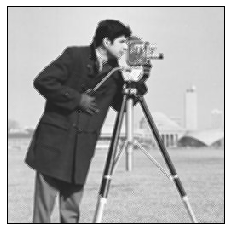

echelle = 2


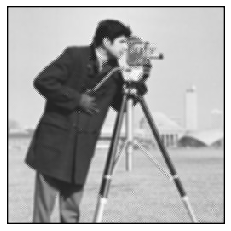

echelle = 3


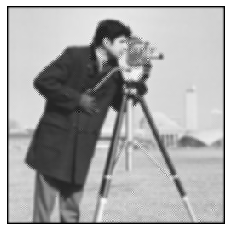

echelle = 4


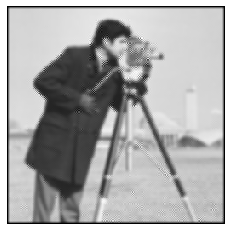

In [11]:
image = Image.open('cameraman.jpg')
N = 5
dt = 0.3
dx = 1
out = heatEquation2D(image, N, dt, dx)


echelle = 1


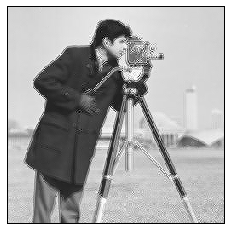

echelle = 2


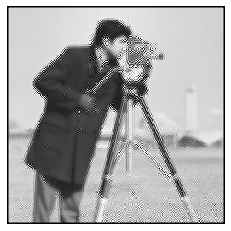

echelle = 3


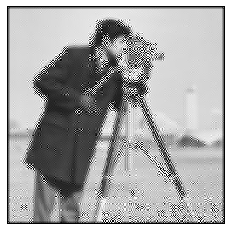

echelle = 4


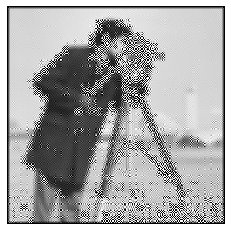

In [12]:
image = Image.open('cameraman.jpg')
N = 5
dt = 0.5
dx = 1
out = heatEquation2D(image, N, dt, dx)


echelle = 1


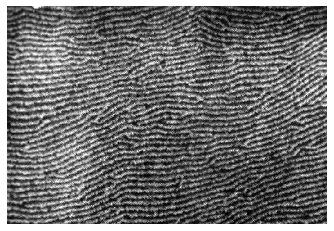

echelle = 2


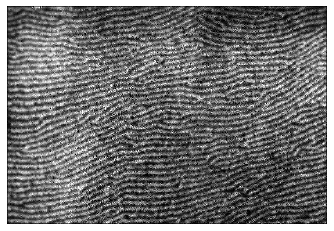

echelle = 3


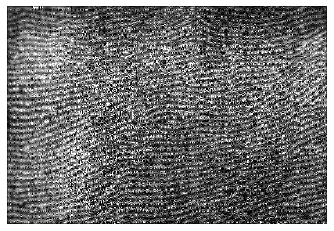

echelle = 4


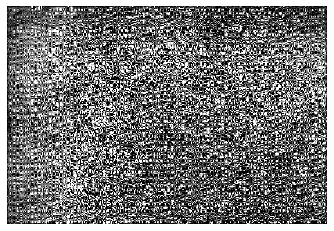

In [13]:
image = Image.open('oyster-s1.jpg')
N = 5
dt = 0.6
dx = 1
out = heatEquation2D(image, N, dt, dx)


echelle = 1


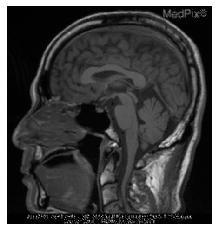

echelle = 2


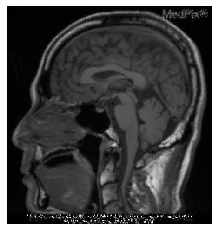

echelle = 3


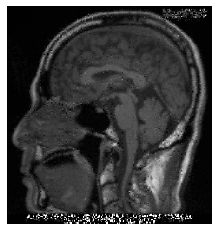

echelle = 4


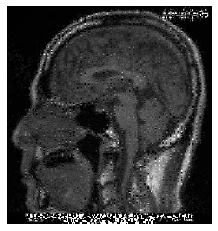

In [0]:
img = Image.open('synpic45657.jpg')
N = 5
dt = 0.5
dx = 1
out = heatEquation2D(img, N, dt, dx)


echelle = 1


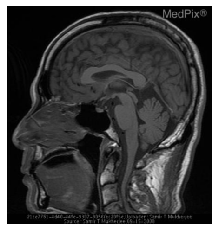

echelle = 2


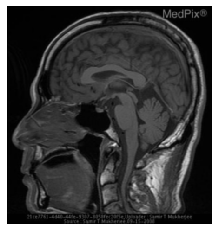

echelle = 3


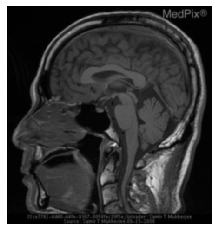

echelle = 4


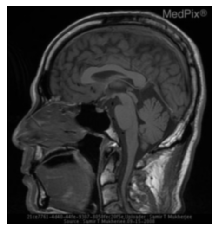

In [14]:
img = Image.open('synpic45657.jpg')
N = 5
dt = 0.2
dx = 1
out = heatEquation2D(img, N, dt, dx)


Observations :
- Disparition des détails au fur et à mesure du lissage 
- Le systeme est conditionnellement stable. 
- Nous devons faire un compromis entre les echantillonnages temporels et spatials.

## Exercie 2 : Perona-Malik Scheme 

In [0]:
from scipy.linalg import toeplitz
from scipy import ndimage

from scipy.ndimage import gaussian_filter
def compute_grad(I):
    """
    Retourne le gradient selon x : G et selon y Gy de l'image I 
    """
    # Get x-gradient in "Gx"
    Gx = gaussian_filter(I, sigma=0.3)
    # Get y-gradient in "Gy"
    Gy = gaussian_filter(I, sigma=0.3)

    return Gx, Gy

def compute_grad_module(I):
    """
    # Get square root of sum of squares
    """
    Gx, Gy = compute_grad(I)
    Gm = np.hypot(Gx,Gy)
    return Gm

In [0]:
def perona_malik(img, dt, k, N ):
  
  """
  Fonction Perona Malik 
  Entrees : 
            data : image en format array 
            dt   : pas de discretisation temporelle
            k    : coeficient de diffusion
            N    : nombre d'échelles 
  Sorties :
            U[n] : image traitée à l'echelle n 

  """
  if img.mode == 'RGB':
    img = img.convert('L')
    # convert image to numpy array
    data = asarray(img)
  else: 
    data = asarray(img)

  #Initialisation
  dataLine   = data.shape[0]
  dataColomn = data.shape[1]
  #print('data shape  = ', data.shape)
        
  #Creation de matrices de N dimension, et de taille (dataLine x dataColomn)
  U = np.zeros((N,dataLine,dataColomn))
  U[0] = data
  dn = np.zeros((N,dataLine,dataColomn))
  ds = np.zeros((N,dataLine,dataColomn))
  de = np.zeros((N,dataLine,dataColomn))
  dw = np.zeros((N,dataLine,dataColomn))

  Cn = np.zeros((N,dataLine,dataColomn))
  Cs = np.zeros((N,dataLine,dataColomn))
  Ce = np.zeros((N,dataLine,dataColomn))
  Cw = np.zeros((N,dataLine,dataColomn))
  Gm = np.zeros((N,dataLine,dataColomn))

  g = np.zeros((N,dataLine,dataColomn))
  for n in range (1, N):
    #Calcul de la magnitude du gradient 
    Gm[n] = compute_grad_module(U[n])
    print('echelle = {:d}'.format(n))
    for i in range(1, data.shape[0]-1):
      for j in range(1,data.shape[1]-1):


        dn [n,i,j] = U[n][i-1][j]-U[n,i,j]
        ds [n,i,j] = U[n][i+1][j]-U[n,i,j]
        de [n,i,j] = U[n][i][j+1]-U[n,i,j]
        dw [n,i,j] = U[n][i][j-1]-U[n,i,j]

        #Calcul de la conductivite de Tukey
        g[n,i,j] = np.exp(-(Gm[n,i,j]**2/k**2))
        #g = np.pad(g, 1, mode='constant')
        #Calcul des coefficients de diffusion
        Cn[n,i,j] = g[n][i][j]
        #print('Cn shape  = ',Cn.shape)
        Cw[n,i,j] = Cn[n,i,j]
        Cs[n,i,j] = g[n,i+1,j]
        Ce[n,i,j] = g[n,i,j+1]

        #Calcul de l'image a chaque echelle
        U[n][i][j] = U[n-1][i][j] + dt * (Cn[n-1,i,j]*dn[n-1,i,j] + Cs[n-1,i,j]*ds[n-1,i,j] + Ce[n-1,i,j]*de[n-1,i,j] + Cw[n-1,i,j]*dw[n-1,i,j])
        
    #Reconversion de format array a l'image et reconversion en NG   
    im_PM = Image.fromarray(U[n]).convert('L')

    #Affichage 
    plt.figure()
    plt.tight_layout();
    plt.axis('off')
    plt.imshow(im_PM,cmap='gray')
    plt.savefig(f'drive/My Drive/im_PeronaMalik_T_{dt}_echelle_{n}.jpeg')
    plt.show()

  return U 




echelle = 1


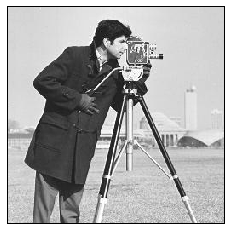

echelle = 2


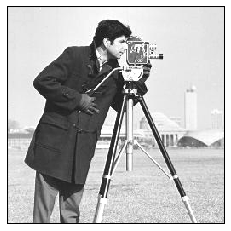

echelle = 3


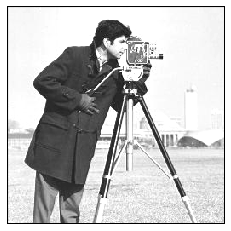

echelle = 4


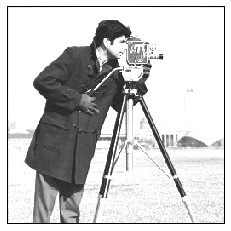

In [20]:
img = Image.open('cameraman.jpg')
dt = 0.04
k = 20
N = 5
out = perona_malik(img, dt, k, N )

echelle = 1


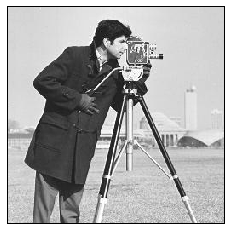

echelle = 2


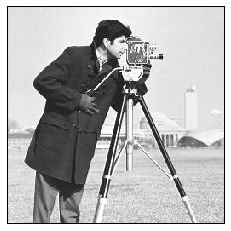

echelle = 3


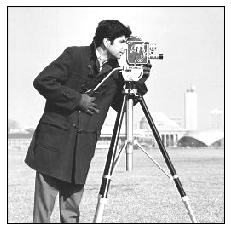

echelle = 4


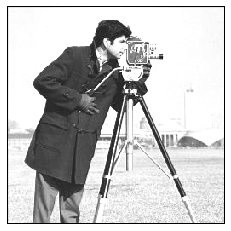

In [23]:
img = Image.open('cameraman.jpg')
dt = 0.03
k = 100
N = 5
out = perona_malik(img, dt, k, N )

echelle = 1


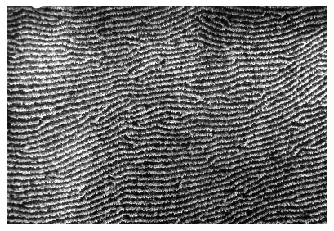

echelle = 2


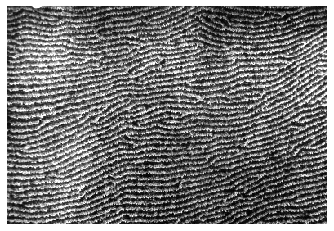

echelle = 3


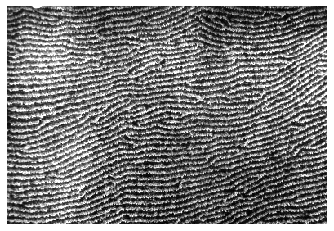

echelle = 4


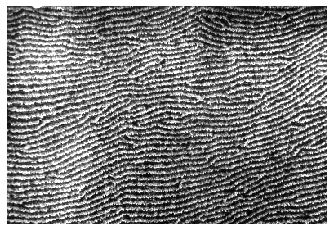

echelle = 5


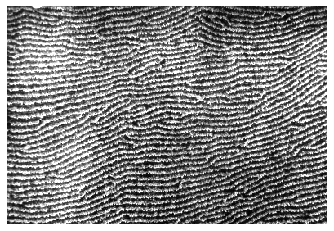

echelle = 6


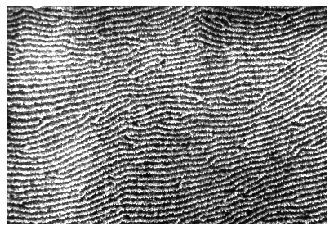

echelle = 7


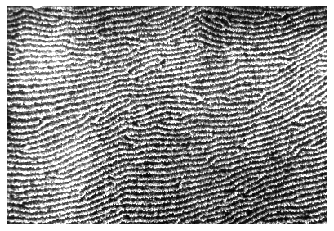

In [24]:
img = Image.open('oyster-s1.jpg')
dt = 0.03
k = 100
N = 8
out = perona_malik(img, dt, k, N )

## Exerice 3 : Edge Enhancing

In [0]:
import os
import skimage.color
import skimage.io

def edgeEnhancing(img, dt, k, N, lambda2):
  
  
  if img.mode == 'RGB':
    img = img.convert('L')
    # convert image to numpy array
    data = asarray(img)
  else: 
    data = asarray(img)

  #Initialisation
  dataLine   = data.shape[0]
  dataColomn = data.shape[1]

  #Creation de matrices de N dimension, et de taille (dataLine x dataColomn)
  U = np.zeros((N,dataLine,dataColomn))
  U[0] = data

  
  Gm = np.zeros((N,dataLine,dataColomn))


  a = np.zeros((N,dataLine,dataColomn))
  b = np.zeros((N,dataLine,dataColomn))
  c = np.zeros((N,dataLine,dataColomn))

  d1 = np.zeros((N,dataLine,dataColomn))
  d2 = np.zeros((N,dataLine,dataColomn))
  d3 = np.zeros((N,dataLine,dataColomn))
  d4 = np.zeros((N,dataLine,dataColomn))
  d5 = np.zeros((N,dataLine,dataColomn))
  d6 = np.zeros((N,dataLine,dataColomn))
  d7 = np.zeros((N,dataLine,dataColomn))
  d8 = np.zeros((N,dataLine,dataColomn))
  d9 = np.zeros((N,dataLine,dataColomn))
  
  lambda1 = 1/5 * lambda2
  
  for n in range (0,N-1):
    print('echelle = {:d}'.format(n))
    Gx, Gy = compute_grad(U)
    #Calcul de la magnitude du gradient 
    Gm[n]= np.hypot(Gx[n],Gy[n])
    for i in range(1, dataLine-1):
      for j in range(1,dataColomn-1):
        #Calcul des des elements du tenseur D
        a[n,i,j] = ((lambda1*Gx[n,i,j]**2) + (lambda2 * Gy[n,i,j]**2)) / Gm[n,i,j]**2
        b[n,i,j] = ((lambda1-lambda2) * Gx[n,i,j]*Gy[n,i,j]) / Gm[n,i,j]**2
        c[n,i,j] = (lambda2*Gx[n,i,j]**2   + lambda1*Gy[n,i,j]**2) / Gm[n,i,j]**2

        d1[n,i,j] = -1/4 * (b[n,i-1,j]+b[n,i,j+1]) * U[n,i-1,j+1]
        d2[n,i,j] =  1/2 * (c[n,i,j+1]+c[n,i,j])   * U[n,i,j+1]
        d3[n,i,j] =  1/4 * (b[n,i+1,j]+ b[n,i,j+1])* U[n,i+1,j+1] 
        d4[n,i,j] =  1/2 * ((a[n,i-1,j]+a[n,i,j])  * U[n,i-1,j])
        d5[n,i,j] = -1/2 * (a[n,i-1,j]+2*a[n,i,j]+a[n,i+1,j]+c[n,i,j-1]+2*c[n,i,j]+c[n,i,j+1])*U[n,i,j]
        d6[n,i,j] =  1/2 * (a[n,i+1,j]+a[n,i,j])     * U[n,i+1,j]
        d7[n,i,j] =  1/4 * (b[n,i-1,j]+b[n,i,j-1]) * U[n,i-1,j]
        d8[n,i,j] =  1/2 * (c[n,i,j-1]+c[n,i,j])   * U[n,i,j-1]
        d9[n,i,j] = -1/4 * (b[n,i+1,j]+b[n,i,j-1]) * U[n,i+1,j-1]

        
        U[n+1,i,j] = U[n,i,j] + dt * ( d1[n,i,j] + d2[n,i,j] + d3[n,i,j] + d4[n,i,j] + d5[n,i,j] + d6[n,i,j] + d7[n,i,j] + d8[n,i,j] + d9[n,i,j])
    
    #Reconversion de format array a l'image puis en NG
    im_EE = Image.fromarray(U[n]).convert('L')
    #Affichage 
    plt.figure()
    plt.tight_layout();
    plt.axis('off')
    plt.imshow(im_EE,cmap='gray')
    plt.savefig(f'drive/My Drive/im_EdgeEnhancing_lambda-{lambda2}_T_{dt}_Echelle_{n}.jpeg')
    plt.show()

  return U 
 

echelle = 0


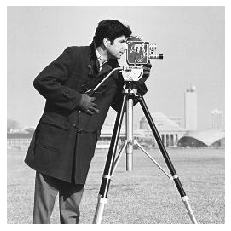

echelle = 1


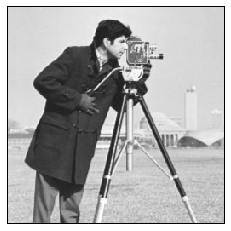

echelle = 2


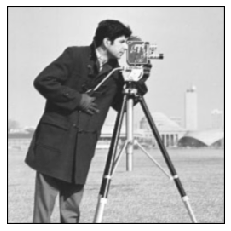

echelle = 3


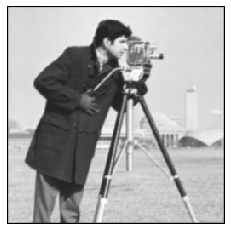

echelle = 4


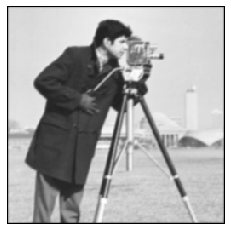

echelle = 5


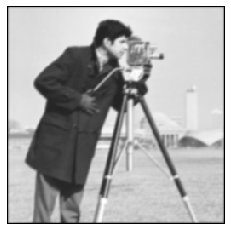

echelle = 6


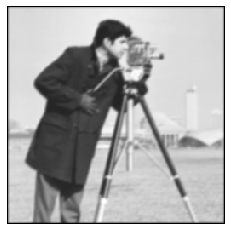

echelle = 7


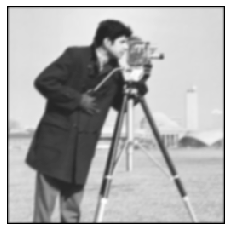

echelle = 8


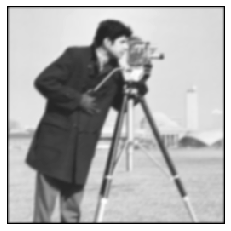

In [28]:
img = Image.open('cameraman.jpg')
out = edgeEnhancing(img, 0.5, 20, 10, 0.6)

echelle = 0


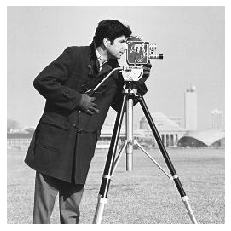

echelle = 1


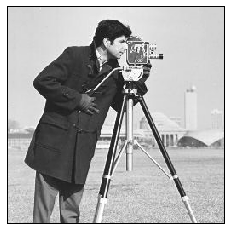

echelle = 2


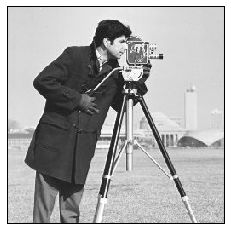

echelle = 3


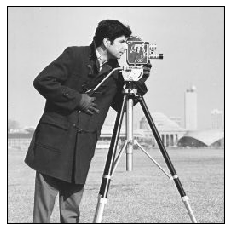

echelle = 4


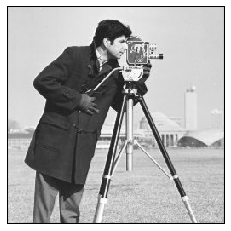

echelle = 5


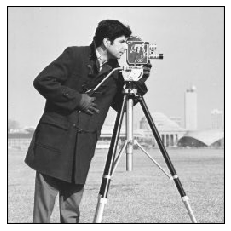

In [58]:
img = Image.open('cameraman.jpg')
out = edgeEnhancing(img, 0.1, 20, 7, 0.4)

echelle = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


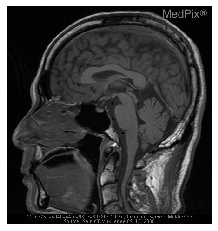

echelle = 1


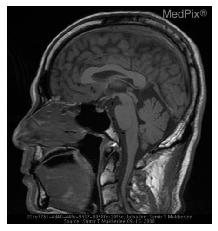

echelle = 2


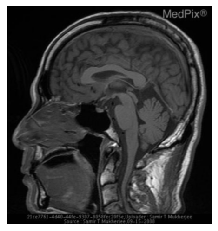

echelle = 3


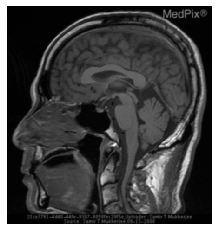

echelle = 4


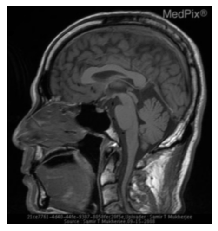

echelle = 5


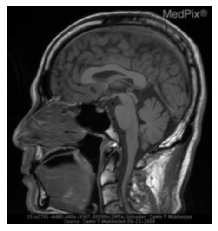

echelle = 6


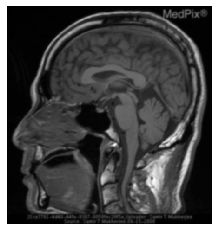

echelle = 7


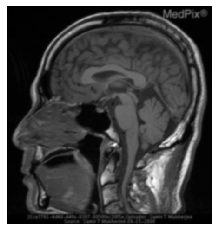

echelle = 8


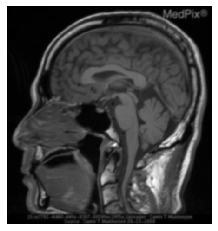

In [59]:
img = Image.open('synpic45657.jpg')
out = edgeEnhancing(img, 0.7, 100,10, 0.5)

echelle = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


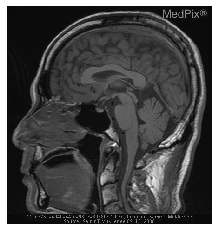

echelle = 2


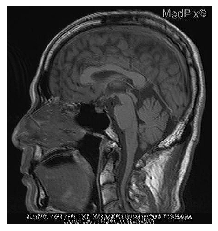

In [0]:
img = Image.open('synpic45657.jpg')
out = edgeEnhancing(img, 1, 100, 3, 0.03)

echelle = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


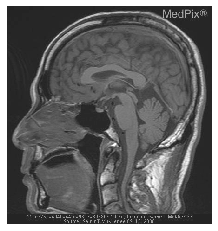

echelle = 2


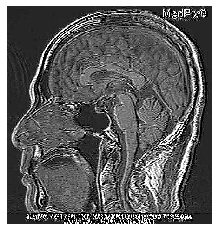

In [0]:
img = Image.open('synpic45657.jpg')
out = edgeEnhancing(img, 4, 100, 3, 0.5)

echelle = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


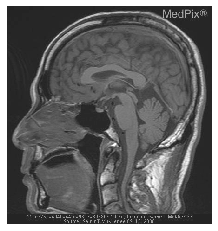

echelle = 2


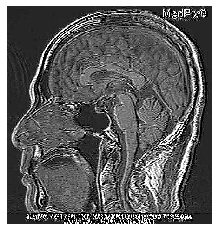

In [0]:
img = Image.open('synpic45657.jpg')
out = edgeEnhancing(img, 4, 20, 3, 0.5)

echelle = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


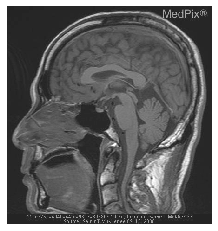

echelle = 2


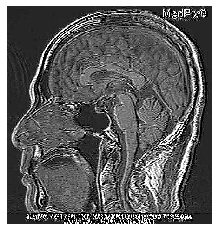

In [0]:
img = Image.open('synpic45657.jpg')
out = edgeEnhancing(img, 4, 20, 3, 0.05)

echelle = 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


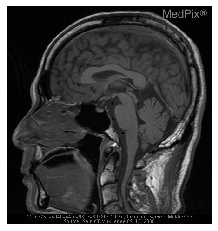

echelle = 1


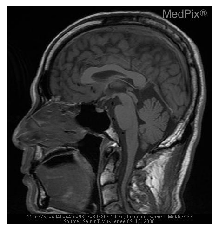

echelle = 2


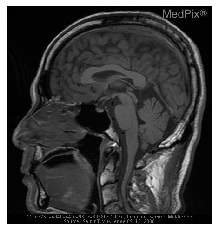

echelle = 3


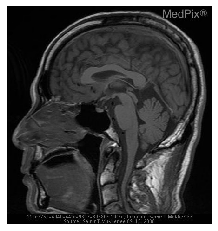

echelle = 4


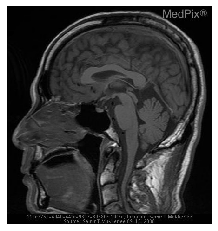

echelle = 5


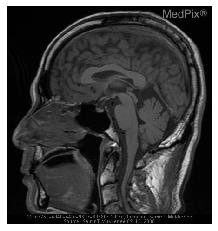

echelle = 6


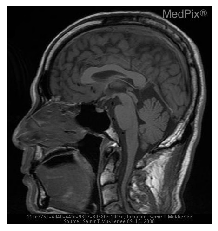

echelle = 7


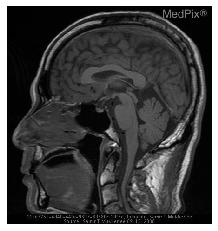

echelle = 8


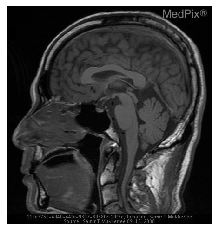

In [56]:
img = Image.open('synpic45657.jpg')
out = edgeEnhancing(img, 0.5, 20, 10, 0.05)

echelle = 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: invalid value encountered in double_scalars


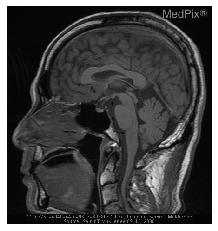

echelle = 2


In [0]:
img = Image.open('synpic45657.jpg')
out = edgeEnhancing(img, 0.5, 100, 10, 0.05)

## Exercice 4 : 2D Implicit Heat Equation

In [0]:
from scipy.sparse import diags
def impliciHeatEquation2D(img, N, alpha):
  if img.mode == 'RGB':
    img = img.convert('L')
    # convert image to numpy array
    data = asarray(img)
  else: 
    data = asarray(img)
    
  dataLine = data.shape[0]
  dataColumn = data.shape[1]
  U = np.zeros((N, data.shape[0],data.shape[1]))
  U[0] = data
  print(data.shape)
  A = diags([1+2*alpha, -alpha, -alpha], [0, -1, 1], shape=data.shape).toarray()
  
  for n in range (0, N-1):
    print('echelle = {:d}'.format(n))
    U[n+1]= np.linalg.solve(A, U[n])
        
    new_im = Image.fromarray(U[n]).convert('L')
    plt.figure()
    plt.tight_layout();
    plt.axis('off')
    plt.imshow(new_im,cmap='gray')
    plt.savefig(f'drive/My Drive/imaImplicit_echelle_{n}.jpeg')
    plt.show()

  return U 
  

(256, 256)
echelle = 0


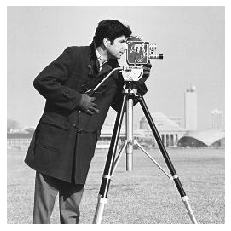

echelle = 1


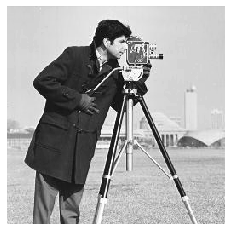

echelle = 2


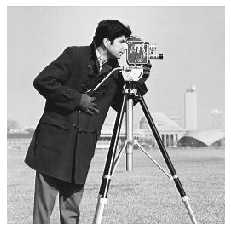

echelle = 3


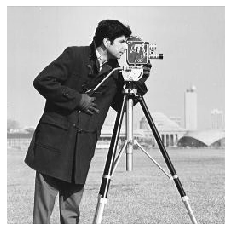

echelle = 4


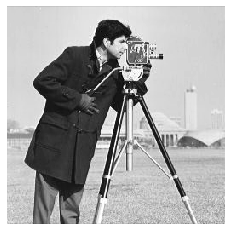

echelle = 5


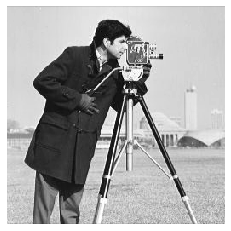

echelle = 6


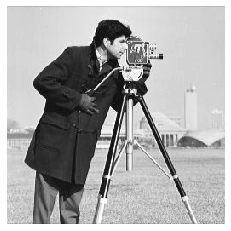

echelle = 7


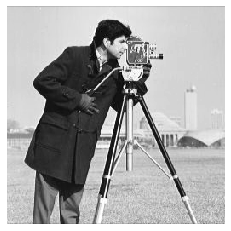

echelle = 8


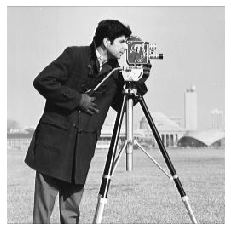

In [55]:
 img = Image.open('cameraman.jpg')
 out = impliciHeatEquation2D(img, 10, 0.02)
